In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from collections import Counter
from imblearn.over_sampling import SMOTE

In [160]:
#read data
train_set_orignal = pd.read_csv('train_set.csv')
train_result_orignal = pd.read_csv('train_result.csv')


#make copy of original data set
train_set = train_set_orignal.copy()
train_result = train_result_orignal.copy()


#drop redundant columns
drop_list = ['id',
			 'date_recorded',
			 'installer',
			 'amount_tsh',
			 'funder',
			 'longitude',
			 'latitude',
			 'wpt_name',
			 'num_private',
			 'basin',
			 'management',
			 'public_meeting',
			 'subvillage',
			 'region_code',
			 'district_code',
			 'lga',
			 'ward',
			 'recorded_by',
			 'scheme_management',
			 'scheme_name',
			 'extraction_type',
			 'extraction_type_class',
			 'extraction_type_group',
			 'management_group',
			 'payment',
			 'water_quality',
			 'quantity',
			 'source',
			 'source_class',
			 'waterpoint_type']


# print(train_set.columns)
train_set.drop(columns = drop_list, inplace = True)	# Dropped all unnecessary columns 
train_result.drop(columns = ['id'], inplace = True) # Dropped id(same order as train_set) from the result set, only contains status_grp now
# print(train_set.columns)

#=======================================================================================================
#delete missing/useless training data
train_set = train_set.join(train_result)   # Include status_group into train_set
# print(train_set.columns)


# Replace values like "other" and "unknown" with nan as they are irrelevant entries
train_set.replace('other', np.nan, inplace = True)
train_set.replace('unknown', np.nan, inplace = True)


# Since construction_year being zero doesn't make sense, replace it with nan
train_set.construction_year.replace(0, np.nan, inplace = True)


# Remove large valued entries from population since it spoils the box plot
# print(len(train_set[train_set["population"]>10000]))  # Only 3 entries above 10000
train_set = train_set[train_set.population < 10000]
#print(train_set["population"].describe())


# In waterpoint_type_group categories like 'cattle trough', 'dam', 'improved spring' had negligible entries, so replace them with nan
# print(train_set["waterpoint_type_group"].unique())
train_set.waterpoint_type_group.replace(['cattle trough', 'dam', 'improved spring'], np.nan, inplace = True)
# print(train_set["waterpoint_type_group"].unique())


# In source_type (Dam and Rainwater Harvesting) had negligible entries, so replace them with nan 
# print(train_set["source_type"].unique())
train_set.source_type.replace(['dam', 'rainwater harvesting'], np.nan, inplace = True)
# print(train_set["source_type"].unique())


# In quality_group, the only useful categories were "salty" and "good", remaining were to be clubbed as 'others"
# print(train_set["quality_group"].unique()) #['good' 'salty' 'milky' nan 'fluoride' 'colored']
quality_group_other_list = ['salty', 'good']
train_set.quality_group = train_set.quality_group.apply(lambda x : x if x in quality_group_other_list else 'other') 
# print(train_set["quality_group"].unique()) #['good' 'salty' 'other']


# Drop all the rows with any value as nan
# print(len(train_set))	# 59394
train_set.dropna(inplace = True)
# print(len(train_set))	# 27845


# Keep the copy of the resulatnt status group seperately into train_result dataFrame, drop it from train_set
train_result = pd.DataFrame(train_set.status_group.copy())	# Create a copy of status_group column from train_set
# print(train_result.columns)	#Index(['status_group'], dtype='object')
# print(len(train_result))	#27845
train_set.drop(columns = ['status_group'], inplace = True)	# Drop status_group from train_set

#=============================================================================================================

# Convert numerical data labels to float 
numerical_data = ['gps_height',
				  'population',
				  'construction_year']
train_set[numerical_data] = train_set[numerical_data].astype('float64') # Convert the columns data type to float


# Transform construction year to age (2013(maxval)-construction_year)
# Make a new column called construction_age and drop construction_year
max_construction_year = train_set.construction_year.max() # Max value - 2013
train_set['construction_age'] = train_set.construction_year.apply(lambda x: max_construction_year - x) #Conversion to age
train_set.drop(columns = ['construction_year'], inplace = True)	# Drop construction_year
# print(train_set["construction_age"])	# Type is already float64, so no need to change data type


# print(train_set.columns)
# Numerical(3) - ['gps_height', 'construction_age', 'population',]
# Categorical(7) -['region', , 'permit', 'payment_type','quality_group', 'quantity_group', 'source_type','waterpoint_type_group']


# Convert String data to Category type(takes only fixed values) 
# Convert status_group in train_result to category as well
categorical_data = ['region',
					'permit',
					'payment_type',
					'quality_group',
					'quantity_group',
					'source_type',
					'waterpoint_type_group']

train_set[categorical_data] = train_set[categorical_data].astype('category')  # Make data type as "category"
train_result = train_result.astype('category')	# Data type of status_group to category  
# print(train_set["region"])

#============================================================================================================
# Making a new category for regions based on their closeness to a water body
# Near,Far

# print(train_set["region"].unique())
# train_set["region"].to_csv("Region.csv")
# https://www.google.com/maps/d/u/0/edit?hl=en&hl=en&mid=1hZWsJC1M3nzeC9imhPlKBoRl5vkYaN-_&ll=-7.824122783997459%2C35.55595008124998&z=6

Near=["Pwani","Dar es Salaam","Lindi","Tanga","Mtwara","Mwanza","Kigoma","Manyara","Singida"]
# Remaining in Far

train_set=train_set.rename(columns={"region":"closeness_to_waterbody"})
# print(train_set.columns)
train_set.closeness_to_waterbody=train_set.closeness_to_waterbody.apply(lambda x:"Near" if x in Near else "Far")
train_set["closeness_to_waterbody"]=train_set["closeness_to_waterbody"].astype("category")
categorical_data = ['closeness_to_waterbody',
					'permit',
					'payment_type',
					'quality_group',
					'quantity_group',
					'source_type',
					'waterpoint_type_group']
# print(train_set["closeness_to_waterbody"])

#=============================================================================================================

#  Creating final csv for the Updated Data Set

# train_set.to_csv("Final_train_set.csv")
# train_result.to_csv("Final_train_result.csv")


#=============================================================================================================

# Plotting for numerical and categorical data

# df1=train_set.join(train_result)
# print(df1)

# Categorical

# closeness_to_waterbody
# df1.groupby(["closeness_to_waterbody", 'status_group']).size().unstack().plot(kind='bar',stacked=True,rot=0)
# plt.show()

# permit
# df1.groupby(["permit", 'status_group']).size().unstack().plot(kind='bar',stacked=True,rot=0)
# plt.show()

# quality_group
# df1.groupby(["quality_group", 'status_group']).size().unstack().plot(kind='bar',stacked=True,rot=0)
# plt.show()

# quantity_group
# df1.groupby(["quantity_group", 'status_group']).size().unstack().plot(kind='bar',stacked=True,rot=0)
# plt.show()

# source_type
# df1.groupby(["source_type", 'status_group']).size().unstack().plot(kind='bar',stacked=True,rot=0)
# plt.show()

# waterpoint_type_group
# df1.groupby(["waterpoint_type_group", 'status_group']).size().unstack().plot(kind='bar',stacked=True,rot=0)
# plt.show()

# payment_type
# df1.groupby(["payment_type", 'status_group']).size().unstack().plot(kind='bar',stacked=True,rot=0)
# plt.show()


# Numerical

# gps_height
# df1.boxplot(by="status_group",column=["gps_height"],grid=False)
# plt.show()

# population
# df1.boxplot(by="status_group",column=["population"],grid=False)
# plt.show()

# construction_age
# df1.boxplot(by="status_group",column=["construction_age"],grid=False)
# plt.show()

#============================================================================================================

# Encoding Categories
train_set_encoded = pd.get_dummies(train_set) # Splits all categorical(data type) columns into respective categories
# print(train_set.columns)
# print(train_set.head())
train_set.reset_index(drop = True, inplace = True)	# Reset index to begin from 0
# print(train_set.columns)
# print(train_set.head())

#============================================================================================================

# Perform operations on train_result
# Categorize data into 2 categories - Functional , (Non Functional,Functional nneeds repair)
store_train_result=train_result.copy()
# print(store_train_result)
train_result['is_non_functional'] = train_result['status_group'].apply(lambda x : 1 if x == 'non functional' else 0)
# print(train_result.head())
train_result.drop(columns = ['status_group'], inplace = True)	# Remove status_group
train_result.reset_index(drop = True, inplace = True)	# Reset index to begin from 0 after dropping status_group
train_set = train_set_encoded
train_set.reset_index(drop = True, inplace = True)

In [161]:
#SMOTE for balancing data
counter = Counter(train_result['is_non_functional'])
print(counter)
oversample = SMOTE()
x, y = oversample.fit_resample(train_set, train_result['is_non_functional'])
counter = Counter(y)
print(counter)

Counter({0: 19413, 1: 8432})
Counter({0: 19413, 1: 19413})


In [162]:
# Classification
# https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
# https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62
# https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
# https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76
# https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
# https://towardsdatascience.com/binary-logistic-regression-using-python-research-oriented-modelling-and-interpretation-49b025f1b510
# https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec


# Split the samples into 0.7 for training and 0.3 for testing
# Using train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    x, y, test_size = 0.3)
# print(type(X_train))
# print(type(Y_train))

0.8216572227536978
0.8204842032967034


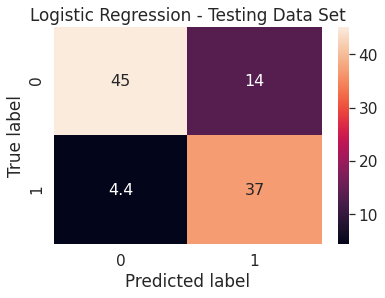

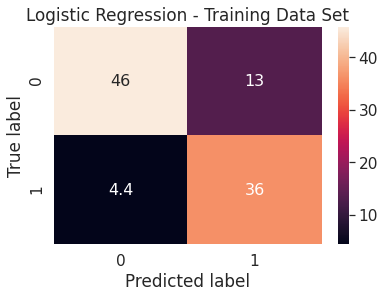

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.891


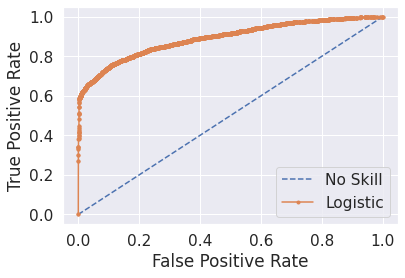

In [163]:
# Logistic Regression
lr = LogisticRegression(max_iter = 4000)
clf = lr.fit(X_train, Y_train)

#score the model on training and testing data
print(lr.score(X_train, Y_train))
print(lr.score(X_test, Y_test))

array = confusion_matrix(lr.predict(X_test), Y_test)
array = pd.DataFrame(array, range(2), range(2))
array = array/array.sum().sum()*100
sns.set(font_scale=1.4) # for label size
sns.heatmap(array, annot=True, annot_kws={"size": 16}) # font size
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Logistic Regression - Testing Data Set')
plt.show()

array = confusion_matrix(lr.predict(X_train), Y_train)
array = pd.DataFrame(array, range(2), range(2))
array = array/array.sum().sum()*100
sns.set(font_scale=1.4) # for label size
sns.heatmap(array, annot=True, annot_kws={"size": 16}) # font size
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Logistic Regression - Training Data Set')
plt.show()

ns_probs = [0 for _ in range(len(Y_test))]
Y_probs = lr.predict_proba(X_test)
Y_probs = Y_probs[:, 1]

ns_auc = roc_auc_score(Y_test, ns_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
lr_auc = roc_auc_score(Y_test, Y_probs)
print('Logistic: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, Y_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

0.9488924865700199
0.8822973901098901


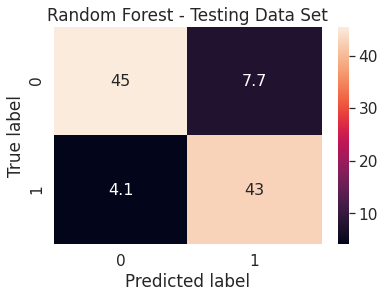

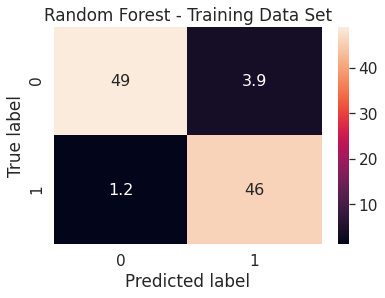

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.951


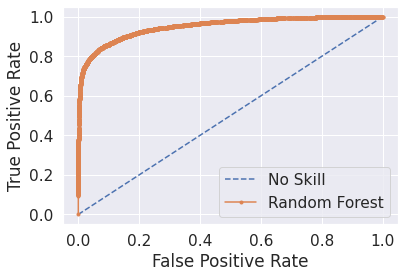

In [176]:
# Random Forest
# rf = RandomForestClassifier()
rf = RandomForestClassifier(min_samples_leaf = 2, min_samples_split = 3)
rf.fit(X_train, Y_train)

#score the model on training and testing data
print(rf.score(X_train, Y_train))
print(rf.score(X_test, Y_test))

#print confusion matrix
array = confusion_matrix(rf.predict(X_test), Y_test)
array = pd.DataFrame(array, range(2), range(2))
array = array/array.sum().sum()*100
sns.set(font_scale=1.4) # for label size
sns.heatmap(array, annot=True, annot_kws={"size": 16}) # font size
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Random Forest - Testing Data Set')
plt.show()

array = confusion_matrix(rf.predict(X_train), Y_train)
array = pd.DataFrame(array, range(2), range(2))
array = array/array.sum().sum()*100
sns.set(font_scale=1.4) # for label size
sns.heatmap(array, annot=True, annot_kws={"size": 16}) # font size
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Random Forest - Training Data Set')
plt.show()

ns_probs = [0 for _ in range(len(Y_test))]
Y_probs = rf.predict_proba(X_test)
Y_probs = Y_probs[:, 1]

ns_auc = roc_auc_score(Y_test, ns_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
rf_auc = roc_auc_score(Y_test, Y_probs)
print('Random Forest: ROC AUC=%.3f' % (rf_auc))

ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(Y_test, Y_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()